## LSTM Autoencoder

This notebook uses an LSTM autoencoder to model the normal behavior of the machine temperature time series. By training the model only on "normal" data, we reconstruct time windows, and flag periods with high reconstruction error as anomalies. The output is evaluated against labeled failures to compute precision, recall, and F1 score.
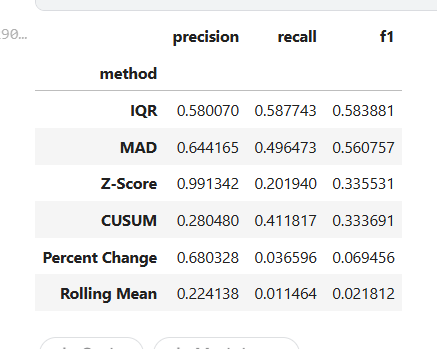

## Imports and load data

In [186]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score


In [187]:
# load data
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/realKnownCause/machine_temperature_system_failure.csv"
df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [188]:
# Load labeled Anomaly Windows
url = "https://raw.githubusercontent.com/hjalalin/nab-anomaly-detection/main/data/labels/combined_windows.json"
response = requests.get(url)
labels = response.json()

anomaly_windows = [
    (pd.to_datetime(start), pd.to_datetime(end))
    for start, end in labels["realKnownCause/machine_temperature_system_failure.csv"]
]

## Train-Test Split and Scaling

We split the dataset chronologically to simulate a real-world early warning scenario.

Rather than using a random or fixed date-based cutoff, we explicitly remove all data points that fall within labeled anomaly windows. This ensures the autoencoder is trained solely on normal, healthy behavior — preventing it from learning patterns associated with failures and preserving the model’s ability to generalize to unseen anomalies.

The entire dataset — including the anomaly periods — is retained for evaluation, allowing us to assess how well the model distinguishes deviations from normal behavior.

Normalization is performed using Min-Max scaling. To avoid data leakage, the scaler is fit only on the clean training data. The same scaler is then applied to both training and test sets to maintain consistency.


In [189]:
def is_in_any_window(ts, windows):
    return any(start <= ts <= end for start, end in windows)

# Mask for training data (before failure + outside anomaly windows)
train_mask = df.index < pd.Timestamp(max(df.index))
for start, end in anomaly_windows:
    train_mask &= ~df.index.to_series().between(start, end)

train_df = df[train_mask]
test_df = df.copy()

# Normalize
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)



## Sequence Generation

The LSTM autoencoder works on sequences of time steps. We convert the continuous time-series into overlapping sequences of fixed length (e.g., 30 time steps). 

This allows the model to learn temporal dependencies and patterns of normal operating behavior.


In [190]:
def create_sequences(data, seq_len):
    xs = []
    for i in range(len(data) - seq_len):
        x = data[i:i+seq_len]
        xs.append(x)
    return np.array(xs)

SEQ_LEN = 5
X_train = create_sequences(train_scaled, SEQ_LEN)
X_test = create_sequences(test_scaled, SEQ_LEN)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)



## LSTM Autoencoder Architecture

The model has two parts:
- **Encoder**: Compresses input sequences into a low-dimensional representation.
- **Decoder**: Attempts to reconstruct the original sequence from this representation.

During inference, high reconstruction error suggests that the current sequence deviates from learned normal behavior — a potential anomaly.


In [191]:
# dataloader
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=64, shuffle=False)


In [192]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(n_features, embedding_dim, batch_first=True)
        self.decoder = nn.LSTM(embedding_dim, n_features, batch_first=True)

    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden = hidden.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        out, _ = self.decoder(hidden)
        return out

model = LSTMAutoencoder(seq_len=SEQ_LEN, n_features=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


## Model Training

We use Mean Squared Error (MSE) as the loss function. The model is trained using Adam optimizer over several epochs. 

The goal is to minimize the reconstruction loss on normal sequences. We expect the model to poorly reconstruct anomalous patterns during inference.


In [193]:
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    losses = []
    for batch_X, _ in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_X)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(losses):.4f}")



Epoch 1, Loss: 0.0301
Epoch 2, Loss: 0.0076
Epoch 3, Loss: 0.0033
Epoch 4, Loss: 0.0029
Epoch 5, Loss: 0.0025
Epoch 6, Loss: 0.0021
Epoch 7, Loss: 0.0017
Epoch 8, Loss: 0.0014
Epoch 9, Loss: 0.0012
Epoch 10, Loss: 0.0011
Epoch 11, Loss: 0.0011
Epoch 12, Loss: 0.0011
Epoch 13, Loss: 0.0011
Epoch 14, Loss: 0.0011
Epoch 15, Loss: 0.0011
Epoch 16, Loss: 0.0011
Epoch 17, Loss: 0.0011
Epoch 18, Loss: 0.0010
Epoch 19, Loss: 0.0010
Epoch 20, Loss: 0.0010


In [194]:
model.eval()
with torch.no_grad():
    X_pred = model(X_test_tensor).numpy()

mse = np.mean(np.power(X_test - X_pred, 2), axis=(1,2))
errors = pd.Series(mse, index=test_df.index[SEQ_LEN:])


## Anomaly Detection

We set a fixed threshold based on the 95th percentile of reconstruction error. Any time window with an error above this threshold is flagged as anomalous.

The choice of threshold is critical — too low leads to false alarms, too high may miss genuine faults. This threshold can be optimized later using precision-recall tradeoffs.


In [195]:
def score_with_windows(detected_times, windows, full_index):
    # Build ground truth vector
    y_true = pd.Series(False, index=full_index)
    for start, end in windows:
        y_true[(full_index >= start) & (full_index <= end)] = True

    # Build prediction vector
    y_pred = pd.Series(full_index.isin(detected_times), index=full_index)

    # Compute metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"precision": precision, "recall": recall, "f1": f1}


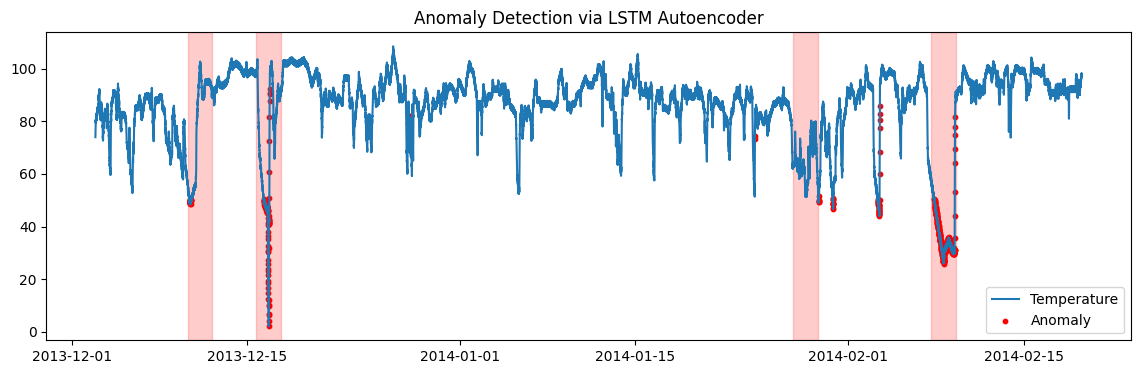

In [196]:
threshold = np.percentile(mse, 97) 
anomalies = errors > threshold

plt.figure(figsize=(14, 4))
plt.plot(df.index, df["value"], label="Temperature")
plt.scatter(errors.index[anomalies], df.loc[errors.index[anomalies]]["value"], color='r', label="Anomaly", s=10)
# Highlight anomaly windows
for start, end in anomaly_windows:
    plt.axvspan(start, end, color='red', alpha=0.2)
plt.legend()
plt.title("Anomaly Detection via LSTM Autoencoder")
plt.show()


In [197]:
# Use timestamps where reconstruction error exceeds threshold
detected_anomaly_times = errors.index[errors > threshold]

full_index = df.index[SEQ_LEN:]

# Compute metrics
score = score_with_windows(detected_anomaly_times, anomaly_windows, full_index)

# Print
print(f"Precision: {score['precision']:.3f}")
print(f"Recall:    {score['recall']:.3f}")
print(f"F1 Score:  {score['f1']:.3f}")


Precision: 0.909
Recall:    0.273
F1 Score:  0.420
